In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display


In [3]:
df= pd.read_csv("banknote_authentication.csv")
display(df.head(10))

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.80730,-0.44699,0
1,4.54590,8.1674,-2.45860,-1.46210,0
2,3.86600,-2.6383,1.92420,0.10645,0
3,3.45660,9.5228,-4.01120,-3.59440,0
4,0.32924,-4.4552,4.57180,-0.98880,0
5,4.36840,9.6718,-3.96060,-3.16250,0
6,3.59120,3.0129,0.72888,0.56421,0
7,2.09220,-6.8100,8.46360,-0.60216,0
8,3.20320,5.7588,-0.75345,-0.61251,0
9,1.53560,9.1772,-2.27180,-0.73535,0


### Data Exploration

In [4]:
df.shape

(1372, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   kurtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [6]:
n_records=len(df)
n_fake_notes= len(df[df['class']==0])
n_real_notes=len(df[df['class']==1])
print("Total number of records: {}".format(n_records))
print("Total number of fake notes: {}".format(n_fake_notes))
print("Total number of real notes: {}".format(n_real_notes))

missing_values= df.isnull().sum().sum()
if missing_values==0:
    print("There is no missing values in the dataset")
else:
    print("There is {} missing values in the dataset".format(missing_values))

Total number of records: 1372
Total number of fake notes: 762
Total number of real notes: 610
There is no missing values in the dataset


In [7]:
display(df.describe())

,variance,skewness,kurtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [8]:
df.corr(numeric_only=True)

,variance,skewness,kurtosis,entropy,class
variance,1.000000,0.264026,-0.380850,0.276817,-0.724843
skewness,0.264026,1.000000,-0.786895,-0.526321,-0.444688
kurtosis,-0.380850,-0.786895,1.000000,0.318841,0.155883
entropy,0.276817,-0.526321,0.318841,1.000000,-0.023424
class,-0.724843,-0.444688,0.155883,-0.023424,1.000000


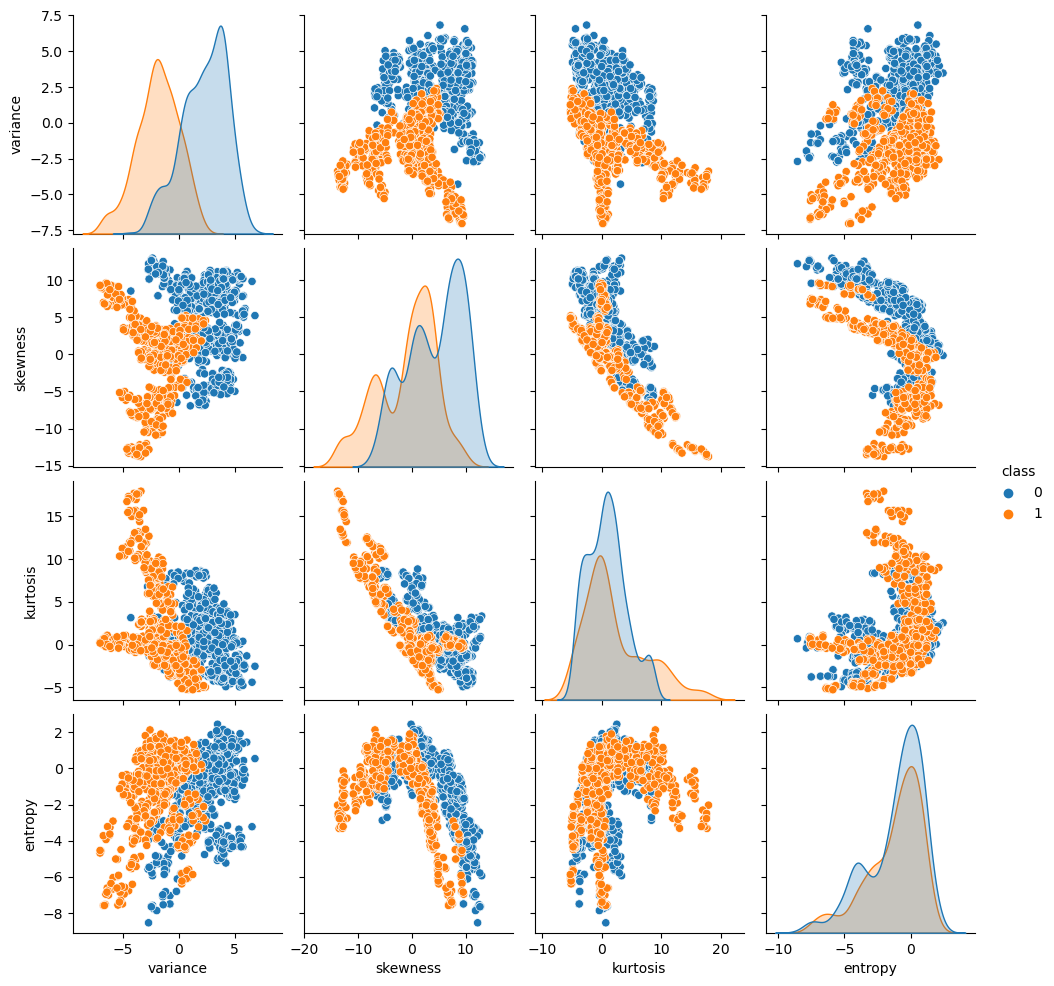

In [9]:
sns.pairplot(df, hue='class')
plt.show()

###### From this pair plot we can make several interesting observations:

The distribution of both variance and skewness appears to be quite different for the two target characteristics, while kurtosis and entropy appear to be more similar.
There are clear linear and nonlinear trends in the input features.
Some characteristics seem to be correlated.
Some features seem to separate genuine and fake banknotes quite well.

In [10]:
target_count=df['class'].value_counts()
target_count

0    762
1    610
Name: class, dtype: int64

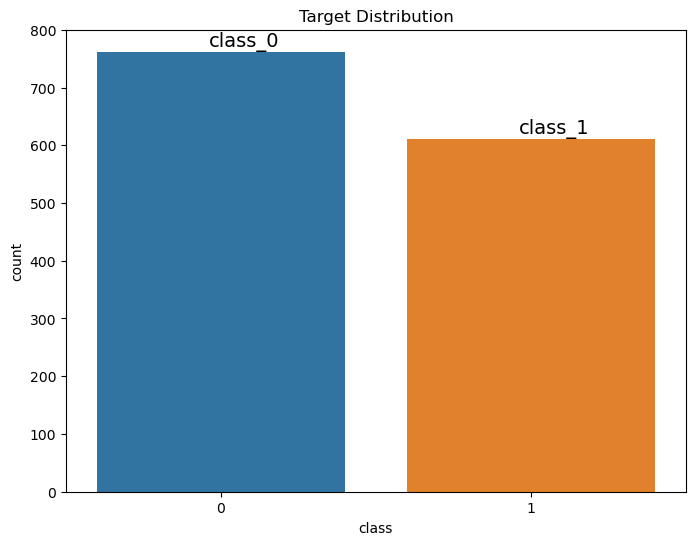

In [11]:
plt.figure(figsize=(8,6))
plt.title('Target Distribution')
sns.countplot(x=df['class'])
plt.annotate('class_0', xy=(-0.04, 10+target_count[0]), size=14)
plt.annotate('class_1', xy=(0.96, 10+target_count[1]), size=14)
plt.show()

###### let's balance our dataset to make equal class

In [12]:
#calculates the number of samples to remove from the majority class
nb_to_delete= target_count[0]-target_count[1]
#randomly shuffles the rows of the DataFrame 
df= df.sample(frac=1, random_state=42).sort_values(by='class')
#removes the first nb_to_delete samples from the DataFrame
df=df[nb_to_delete:]
print(df['class'].value_counts())

0    610
1    610
Name: class, dtype: int64


### Segregate data into X and y

In [13]:
X= df.drop('class', axis='columns')
y=df['class']

##### Normalizing Numerical Features

In [14]:
from sklearn.preprocessing import MinMaxScaler
numerical_col=['variance', 'skewness','kurtosis','entropy']
scaler= MinMaxScaler()
X[numerical_col]=scaler.fit_transform(X[numerical_col])
display(X.head(n=6))


,variance,skewness,kurtosis,entropy
311,0.870548,0.329384,0.378599,0.739666
30,0.489943,0.508710,0.439094,0.777626
242,0.626146,0.648161,0.287871,0.727388
136,0.899992,0.869608,0.014836,0.382865
310,0.797842,0.414325,0.335227,0.798173
596,0.555068,0.709254,0.273694,0.721876


### Model Building

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold


In [16]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [17]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=3)

scores_gradientBoosting = []
scores_knn = []
scores_svm = []
scores_logistic = []

for train_index, test_index in folds.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scores_gradientBoosting.append(get_score(GradientBoostingClassifier(), X_train, X_test, y_train, y_test))
    scores_knn.append(get_score(KNeighborsClassifier(), X_train, X_test, y_train, y_test))
    scores_svm.append(get_score(SVC(gamma='auto'), X_train, X_test, y_train, y_test))
    scores_logistic.append(get_score(LogisticRegression(solver='liblinear',multi_class='ovr'), X_train, X_test, y_train, y_test))


In [18]:
scores_gradientBoosting

[0.9926289926289926, 0.9975429975429976, 0.9950738916256158]

In [19]:
scores_knn

[1.0, 1.0, 1.0]

In [20]:
scores_svm

[0.9778869778869779, 0.9852579852579852, 0.9827586206896551]

In [21]:
scores_logistic

[0.9090909090909091, 0.9656019656019657, 0.9630541871921182]

In [22]:
from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

1.0

In [23]:
y_pred= model.predict(X_test)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### Model Evaluation

Text(50.722222222222214, 0.5, 'Thruth')

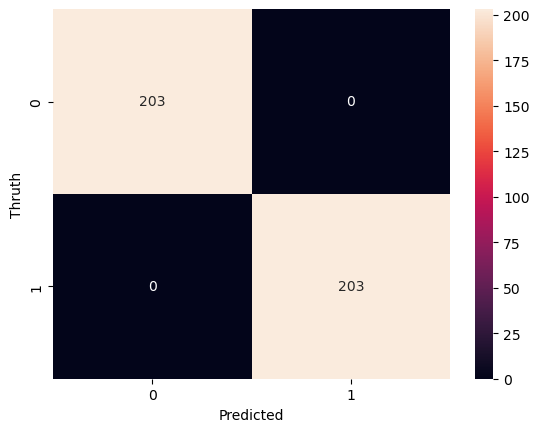

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Thruth')

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       203
           1       1.00      1.00      1.00       203

    accuracy                           1.00       406
   macro avg       1.00      1.00      1.00       406
weighted avg       1.00      1.00      1.00       406

